<a href="https://colab.research.google.com/github/AnnaZhuravleva/compling/blob/master/assignment_3/assignment_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 3

1. Implement Logistic Regression with Stochastic Gradient Decent using numpy
1. Implement Logistic Regression with early stopping using pytorch

Additional readings:
1. https://www.pythonlikeyoumeanit.com/Module3_IntroducingNumpy/VectorizedOperations.html
1. https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.base import ClassifierMixin
from sklearn.datasets import fetch_20newsgroups
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer

# retrieve dataset
data = fetch_20newsgroups()


X_train = data['data']
y_train = data['target']

tfidf = TfidfVectorizer(max_df=0.5, min_df=10)
X_train = tfidf.fit_transform(X_train)

test_data = fetch_20newsgroups(subset='test')
X_test = tfidf.transform(test_data['data'])
y_test = test_data['target']

## 1 Binary Logistic Regression
$\{(x_i, y_i)\}_{i=1}^N$, $y \in \{0,1\}$
$$ z = Xw + b $$

$$p(y=1 | x) = \sigma(z) = \frac 1 {1 + e^{-z}}$$

$$ L_{batch} = - \frac 1 {|batch|} \sum_{i \in batch}^N [ y_i \log \sigma(z_i) + (1 - y_i) \log (1 - \sigma(z_i)) ] + \frac \lambda 2 w^T w$$

Stochastic Gradient Decent for logreg:
1. init w ~ random N(0,1), b = 0
1. for epoch = 1..n_epochs:
    * shuffle dataset
    * for every batch:
        * $w^{(t)} \leftarrow w^{(t-1)} - \alpha \nabla_{w} L_{batch}(w^{(t-1)},b^{(t-1)})$
        * $b^{(t)} \leftarrow b^{(t-1)} - \alpha \nabla_{b} L_{batch}(w^{(t-1)},b^{(t-1)})$
        
$w$ - weights  
$b$ - biases  
$\alpha$ - learning rate

Hint:
$$\nabla_w L = \frac {\partial L} {\partial \sigma} \frac {\partial \sigma} {\partial z} \frac {\partial z} {\partial w} + \frac {\partial (\frac \lambda 2 w^T w)} {\partial w} $$
$$\nabla_b L = \frac {\partial L} {\partial \sigma} \frac {\partial \sigma} {\partial z} \frac {\partial z} {\partial b} $$

In [2]:
# make dataset for binary classification

X_train_bin = X_train[y_train < 2]
y_train_bin = y_train[y_train < 2]

X_test_bin = X_test[y_test < 2]
y_test_bin = y_test[y_test < 2]

y_train_bin.shape, y_test_bin.shape

((1064,), (708,))

$$ \frac {\partial L} {\partial \sigma}  = \frac {y - y_i} {y (1 - y)}$$

 $$\frac {\partial y} {\partial z} = \frac {exp(-z)} {(1 + exp(-z))^2} = y * (1 - y) $$
 $$ \frac {\partial z} {\partial w}  =  X^T$$ 
 
 $$\frac {\partial (\frac \lambda 2 w^T w)} {\partial w} = \lambda * w $$

 $$\nabla_w L = \frac {y - y_i} {y (1 - y)} *  y * (1 - y) * X^T =(y - y_i ) X^T  $$

 where $$ y = \sigma(x)$$

$$\nabla_b L = \frac {\partial L} {\partial \sigma} \frac {\partial \sigma} {\partial z} \frac {\partial z} {\partial b}  = \frac {\partial L} {\partial \sigma} \frac {\partial \sigma} {\partial z} = (y - y_i ) $$

$$ \frac {\partial z} {\partial b}  = 1$$


auc 0.8446059746476375


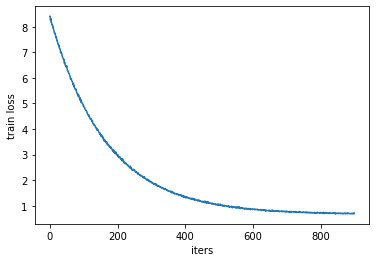

In [3]:
class LogRegNumpy(ClassifierMixin):
    def __init__(self, llambda=1, lr=0.1, batch_size=32, n_epochs=100):
        """
        llambda: regularization strength
        lr: learning rate
        """
        self.w = None
        self.b = 0
        self.llambda = llambda
        self.n_epochs = n_epochs
        self.lr = lr
        self.history = []
        self.batch_size = batch_size
        
    def fit(self, X, y):
        self.w = np.random.randn(X.shape[1])
        self.b = 0

    def get_loss(self, y, batch_X, batch_y):
        loss =  batch_y * np.log(y) + (1 - batch_y)*np.log(1 - y)
        loss =  - np.sum(loss) / batch_X.shape[0]
        loss += (self.llambda/2) * self.w.T.dot(self.w)
        return loss
    
    def fit(self, X, y):
        self.w = np.random.randn(X.shape[1])
        self.b = 0
            
        for epoch in range(self.n_epochs):
            
            # random permutation over indices of dataset
            batch_indices = np.random.permutation(len(y))
            
            for j in range(0, len(y), self.batch_size):
                batch_idx = batch_indices[j:j+self.batch_size]
                batch_X = X[batch_idx]
                batch_y = y[batch_idx]
            
                # forward pass
                # <TODO> [1 point] calculate batch loss
                pred_y = self.predict_proba(batch_X)
                loss = self.get_loss(pred_y, batch_X, batch_y)
                delta_y = pred_y - batch_y

                # backward pass
                # <TODO> [2 points] calculate batch gradients
                grad_w = (1 / batch_X.shape[1]) * batch_X.T.dot(delta_y) + self.llambda * self.w
                grad_b = (1 / batch_X.shape[1]) * np.sum(delta_y)

                # SGD optimization step
                # <TODO> [1 point]
                self.w -= self.lr * grad_w
                self.b -= self.lr * grad_b 
                
                self.history.append(loss)
        
        return self 
    
    def predict_proba(self, X):
        # <TODO> [1 point] calculate p(y=1 | x)
        z = X.dot(self.w) + self.b
        return  1 / (1 + np.exp(-z))
    
    def predict(self, X):
        return (self.predict_proba(X) > 0.5).astype(np.int)
    
    
model = LogRegNumpy(llambda = 0.001, lr=3, batch_size=128, n_epochs=100)
model.fit(X_train_bin, y_train_bin)
print('auc', metrics.roc_auc_score(y_test_bin, model.predict_proba(X_test_bin)))

plt.plot(np.arange(len(model.history)), model.history)
plt.xlabel('iters')
plt.ylabel('train loss');

# Multinomial Logistic Regression using pytorch

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split

###  [1 point] implement linear model $Z = XW + b$

In [0]:
class LogRegNN(nn.Module):
    
    def __init__(self, n_features, n_classes):
        super(LogRegNN, self).__init__()
        
        # create tensor of weights and tensor of biases
        # initialize tensors from N(0,1) 
        # W has shape (n_features, n_classes)
        # b has shape (n_classes,)
        self.W = nn.Parameter(torch.randn(n_features, n_classes))
        self.b = nn.Parameter(torch.randn(n_classes))
        
    def forward(self, x):
        """
        In this method we implement connections between neural network weights
        x: batch feature matrix
        returns: probability logits
        """
        # <TODO> implement linear model 
        result = x @ self.W + self.b
        return result

In [0]:
def train_batch(model, batch_x, batch_y):
    # set NN model in training mode
    model.train()
    
    # zero gradients
    optimizer.zero_grad()
    # forward pass
    pred = model(batch_x)
    # cross-entropy loss
    loss = criterion(pred, batch_y)
    # calculate gradients
    loss.backward()
    # make optimization step
    optimizer.step()
    
    # return batch loss
    return loss.data.detach().item()

def eval_batch(model, batch_x, batch_y):
    # set NN model in evaluation mode
    model.eval()
    
    with torch.no_grad():
        # forward pass
        pred = model(batch_x)
        # cross-entropy loss
        loss = criterion(pred, batch_y)

    # return batch loss
    return loss.data.item()

### [2 points] implement early stopping using early_stopping_patience

In [0]:
def early_stopping(loss, patience=5):
    if len(loss) < patience:
        return False
    best = np.min(np.array(loss))
    return all(map(lambda x: x > best, loss[-patience:]))

In [0]:
def train(model, train_loader, valid_loader, n_epochs, early_stopping_patience=5):
    """
    early_stopping_patience - number of consecutive epochs of growing validation loss to wait
    """
    history = {'train': [], 'valid': []}

    # <TODO> implement early stopping using early_stopping_patience
    
    for epoch in range(n_epochs):
        epoch_train_loss = 0
        
        # iterate over batches
        for batch_x, batch_y in tqdm(train_loader, desc=f'epoch:{epoch}', leave=True):

            loss = train_batch(model, batch_x, batch_y)
            epoch_train_loss += loss

        # average loss for epoch
        epoch_train_loss /= len(train_loader)
        history['train'].append(epoch_train_loss)
        
        epoch_valid_loss = 0
        for batch_x, batch_y in valid_loader:
            loss = eval_batch(model, batch_x, batch_y)
            epoch_valid_loss += loss
            
        epoch_valid_loss /= len(valid_loader)
        print(f'train loss: {epoch_train_loss:.3f} valid loss:{epoch_valid_loss:.3f}')
        history['valid'].append(epoch_valid_loss)
        
        # <TODO> implement early stopping using early_stopping_patience
        if early_stopping(history['valid'], patience=5):
            print('early stopping')
            break

    print('history valid:', history['valid'])
    return history 

### predict hard labels [1 point]

In [0]:
def predict(model, test_loader):
    
    model.eval()
    
    result = []
    with torch.no_grad():
        for batch_x in test_loader:
            # <TODO> predict hard labels
            tmodel = model.forward(batch_x)
            pred = np.argmax(F.softmax(tmodel), axis = 1)
            result.append(pred)
    return np.concatenate(result)

DataLoader implements iteration over batches and shuffling

L2 regularization coef is embedded into SGD.weight_decay: 

1. $w^{(t-1)} \leftarrow w^{(t-2)} - \alpha \lambda w^{(t-2)} $  
1. $w^{(t)} \leftarrow w^{(t-1)} - \alpha \nabla_{w} L(w^{(t-1)}) $

here   
$\alpha$ - learning rate  
$\lambda$ - weight-decay = L2 regularization coef

In [10]:
X_train2, X_valid2, y_train2, y_valid2 = train_test_split(X_train, y_train, stratify=y_train,
                                                      shuffle=True, test_size=0.2, random_state=42)

batch_size = 256


train_loader = DataLoader(TensorDataset(torch.tensor(X_train2.todense()).float(), torch.tensor(y_train2).long()), 
                          batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(TensorDataset(torch.tensor(X_valid2.todense()).float(), torch.tensor(y_valid2).long()), 
                          batch_size=batch_size)
test_loader = DataLoader(torch.tensor(X_test.todense()).float(), 
                          batch_size=batch_size)

model = LogRegNN(X_train.shape[1], 20)

criterion = nn.CrossEntropyLoss()
# L2 regularization is embeded in 
optimizer = optim.SGD(model.parameters(), lr=10.0, weight_decay=0.0001)

history = train(model, train_loader, valid_loader, 100, 2)


train loss: 3.270 valid loss:3.034



train loss: 2.836 valid loss:2.692



train loss: 2.489 valid loss:2.409



train loss: 2.200 valid loss:2.177



train loss: 1.963 valid loss:1.993



train loss: 1.779 valid loss:1.842



train loss: 1.627 valid loss:1.729



train loss: 1.500 valid loss:1.632



train loss: 1.397 valid loss:1.542



train loss: 1.309 valid loss:1.464



train loss: 1.233 valid loss:1.391



train loss: 1.172 valid loss:1.351



train loss: 1.118 valid loss:1.301



train loss: 1.072 valid loss:1.262



train loss: 1.031 valid loss:1.225



train loss: 0.991 valid loss:1.203



train loss: 0.965 valid loss:1.167



train loss: 0.938 valid loss:1.148



train loss: 0.912 valid loss:1.129



train loss: 0.890 valid loss:1.111



train loss: 0.874 valid loss:1.095



train loss: 0.856 valid loss:1.086



train loss: 0.838 valid loss:1.068



train loss: 0.822 valid loss:1.053



train loss: 0.811 valid loss:1.051



train loss: 0.802 valid loss:1.048



train loss: 0.790 valid loss:1.028



train loss: 0.783 valid loss:1.023



train loss: 0.774 valid loss:1.019



train loss: 0.768 valid loss:1.009



train loss: 0.758 valid loss:1.002



train loss: 0.753 valid loss:0.998



train loss: 0.748 valid loss:0.992



train loss: 0.740 valid loss:0.991



train loss: 0.740 valid loss:0.988



train loss: 0.731 valid loss:0.980



train loss: 0.725 valid loss:0.977



train loss: 0.724 valid loss:0.981



train loss: 0.722 valid loss:0.975



train loss: 0.718 valid loss:0.975



train loss: 0.713 valid loss:0.970



train loss: 0.712 valid loss:0.967



train loss: 0.711 valid loss:0.968



train loss: 0.706 valid loss:0.960



train loss: 0.707 valid loss:0.965



train loss: 0.703 valid loss:0.961



train loss: 0.703 valid loss:0.959



train loss: 0.700 valid loss:0.963



train loss: 0.698 valid loss:0.967



train loss: 0.697 valid loss:0.958



train loss: 0.696 valid loss:0.958



train loss: 0.694 valid loss:0.958



train loss: 0.693 valid loss:0.953



train loss: 0.691 valid loss:0.952



train loss: 0.690 valid loss:0.951



train loss: 0.690 valid loss:0.956



train loss: 0.689 valid loss:0.949



train loss: 0.688 valid loss:0.954



train loss: 0.687 valid loss:0.951



train loss: 0.686 valid loss:0.948



train loss: 0.685 valid loss:0.952



train loss: 0.685 valid loss:0.950



train loss: 0.685 valid loss:0.957



train loss: 0.684 valid loss:0.948



train loss: 0.683 valid loss:0.952



train loss: 0.682 valid loss:0.948



train loss: 0.682 valid loss:0.951



train loss: 0.681 valid loss:0.945



train loss: 0.682 valid loss:0.948



train loss: 0.681 valid loss:0.946



train loss: 0.681 valid loss:0.954



train loss: 0.679 valid loss:0.945



train loss: 0.681 valid loss:0.946
early stopping
history valid: [3.0341389973958335, 2.692186541027493, 2.4085853629642062, 2.1768796973758273, 1.9932651784684923, 1.841540601518419, 1.7290611664454143, 1.631886879603068, 1.5418658388985529, 1.464384184943305, 1.3907251358032227, 1.3509521749284532, 1.3005655739042494, 1.2620928552415636, 1.2253605789608426, 1.2027656767103407, 1.1673084497451782, 1.1481957965426974, 1.1293718020121257, 1.1105744573805068, 1.095452004008823, 1.085776103867425, 1.0683172676298354, 1.0532917777697246, 1.0514035357369318, 1.0480328599611919, 1.0282886624336243, 1.0227058993445501, 1.0187520451015897, 1.0094619923167758, 1.0023805896441143, 0.9976000719600253, 0.9917451275719537, 0.9913938575320773, 0.9880031877093844, 0.9804965986145867, 0.9768709540367126, 0.9806347091992696, 0.9749261008368598, 0.9749236173099942, 0.9700839718182882, 0.9669530325465732, 0.9678794609175788, 0.9596595697932773, 0.9654960698551602, 0.9608851803673638, 0.9586534963713752,

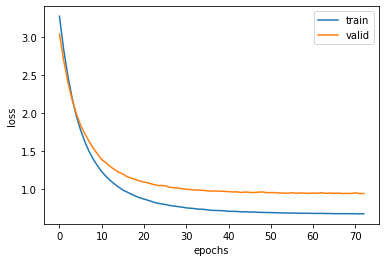

In [11]:
plt.plot(np.arange(len(history['train'])), history['train'], label='train')
plt.plot(np.arange(len(history['valid'])), history['valid'], label='valid')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

In [12]:
y_pred = predict(model, test_loader)
metrics.accuracy_score(y_test, y_pred)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # Remove the CWD from sys.path while we load stuff.


0.8076208178438662

### What is the cross-entropy loss of uniformly random guessing classifier for this task? [0.5 point]

In [13]:
random_classifier = np.random.uniform(0, 1, (y_test.shape[0], len(np.unique(y_test))))
c = criterion(torch.tensor(random_classifier), torch.tensor(y_pred))
print(f'Cross-entropy loss of uniformly random guessing classifier - {c}')

Cross-entropy loss of uniformly random guessing classifier - 3.039165171392545


### What is the accuracy of constant prediction classifier for this task? [0.5 point]

In [14]:
ac_metric = metrics.accuracy_score(y_test, [1] * y_test.shape[0])
print(f"Accuracy of constant prediction classifier = {ac_metric}")

Accuracy of constant prediction classifier = 0.05164630908125332
